In [15]:
import numpy as np
import pandas as pd
from scipy.linalg import expm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = (15, 10)

In [91]:
def get_qmat(μ, a,
             q_inf_U=0.3,
             q_inf_D=0.4,
             q_rec_D=0.5,
             q_rec_U=0.4,
             λ=0.8,
             β_UU=0.3,
             β_UD=0.4,
             β_DU=0.3,
             β_DD=0.4,
             ν_H=0.6):
    '''
    Get infinitesimal generator matrix given measure and action
    Input:
    μ: dictionary or pd.series like {'DI': 0.25, 'DS': 0.25, 'UI': 0.25, 'US': 0.25}
    a: action in [0, 1]
    
    Output:
    Q: 4 X 4 matrix
    '''
    if a == 0:
        Q = np.array([
            [-q_rec_D, q_rec_D, 0, 0],
            [ν_H*q_inf_D + β_DD*μ['DI'] + β_UD*μ['UI'], - (ν_H*q_inf_D + β_DD*μ['DI'] + β_UD*μ['UI']), 0, 0],
            [0, 0, -q_rec_U , q_rec_U],
            [0, 0, ν_H*q_inf_U + β_UU*μ['UI']+ β_DU*μ['DI'], -(ν_H*q_inf_U + β_UU*μ['UI']+ β_DU*μ['DI'])]   
            ])
    elif a == 1:
        Q = np.array([
            [-(q_rec_D+λ), q_rec_D, λ, 0],
            [ν_H*q_inf_D + β_DD*μ['DI'] + β_UD*μ['UI'], - (ν_H*q_inf_D + β_DD*μ['DI'] + β_UD*μ['UI'] + λ), 0, λ],
            [λ, 0, -(q_rec_U+λ) , q_rec_U],
            [0, λ, ν_H*q_inf_U + β_UU*μ['UI']+ β_DU*μ['DI'], -(ν_H*q_inf_U + β_UU*μ['UI']+ β_DU*μ['DI']+λ)]   
            ])
    return Q

def get_f(k_D= 0.3, k_I= 0.5):
    '''
    Running cost function
    '''
    k = np.array([k_D + k_I, k_D, k_I, 0])
    return k

def solve_hjb(μ_flow, param_q, param_f):
    '''
    Solve discrete dynamic programming given a fixed 
    '''
    a_space = [0, 1]
    u = pd.DataFrame(np.zeros(μ_flow.shape),
                     index=μ_flow.index, columns=μ_flow.columns)             # initialize value function
    a_flow = pd.DataFrame(np.zeros(μ_flow.shape),
                          index=μ_flow.index, columns=μ_flow.columns)        # initialize action flow
    dt = μ_flow.index[1]                                                     # get time step
    
    f = get_f(**param_f)
    for t in reversed(range(len(u)-1)):
        μ = μ_flow.iloc[t]
        Q = [get_qmat(μ, a, **param_q) for a in a_space]                     # Q matrix by μ and action
        P = [expm(q*dt) for q in Q]
        
        Hdt = np.vstack([p@u.iloc[t+1] +  f*dt for p in P])  # Halmitonian * dt (7.33)
        Hdt_min = Hdt.min(axis=0)                                            # min Halmitonian
        a = Hdt.argmin(axis=0)                                               # corresponding action
        u.iloc[t] = Hdt_min                                                  # record value funtion at t
        a_flow.iloc[t] = a                                                   # record action at t
    return a_flow

def solve_flow(μ0, a_flow, param_q, param_f):
    μ_flow = pd.DataFrame(np.zeros(a_flow.shape),
                          index=a_flow.index, columns=a_flow.columns)
    μ_flow.iloc[0] = μ0
    
    t_len, x_len = a_flow.shape
    dt = a_flow.index[1]
    
    for t in range(t_len-1):
        μ = μ_flow.iloc[t]
        ax = a_flow.iloc[t]
        μ_new = μ @ [expm(get_qmat(μ, ax[x], **param_q) *dt)[x]             # KFP eqn (7.36)
                     for x in range(x_len)]
        μ_flow.iloc[t+1] = μ_new
    return μ_flow

def solve_fixpoint(μ0, param_q, param_f, T=10, n=1000, iterations=1):
    tline = np.linspace(0, T, n+1)
    dt = T/n
    μ_flow = pd.DataFrame(np.random.dirichlet(np.ones(len(μ0)), size=len(tline)),
                          index=tline, columns=μ0.index)

    a_flow_list = []
    μ_flow_list = []
    for i in range(iterations):
        a_flow = solve_hjb(μ_flow, param_q, param_f)
        μ_flow = solve_flow(μ0, a_flow, param_q, param_f)


        μ_flow_list.append(μ_flow)
        a_flow_list.append(a_flow)
    
    return (μ_flow_list, a_flow_list)

In [153]:
param_plot={
    'style': ['-', '--', ':', '-.'],
    'color': ['black', 'red', 'green', 'blue'],
    'ylim': [-0.02,1.02],
    'xlim': [-0.2, T+0.2]
}

# parameter set 1
param_q = {'q_inf_U': 0.3,
         'q_inf_D': 0.4,
         'q_rec_D': 0.5,
         'q_rec_U': 0.4,
         'λ': 0.8,
         'β_UU': 0.3,
         'β_UD': 0.4,
         'β_DU': 0.3,
         'β_DD': 0.4,
         'ν_H': 0.6,
}

param_f = {
    'k_D': 0.3,
    'k_I': 0.5
}


# parameter set 2
param_q2 = {'q_inf_U': 0.3,
         'q_inf_D': 0.4,
         'q_rec_D': 0.3,
         'q_rec_U': 0.3,
         'λ': 1000,
         'β_UU': 5,
         'β_UD': 5,
         'β_DU': 2,
         'β_DD': 2,
         'ν_H': 0.6,
}

param_f2 = {
    'k_D': 0.5385,
    'k_I': 1
}

# Fig 7.1

In [156]:
μ0_1 = pd.Series([0.25, 0.25, 0.25, 0.25], index=['DI', 'DS', 'UI', 'US'])
μ0_2 = pd.Series([1, 0, 0, 0], index=['DI', 'DS', 'UI', 'US'])
μ0_3 = pd.Series([0, 0, 0, 1], index=['DI', 'DS', 'UI', 'US'])
μ0_4 = pd.Series([0, 0, 0.44, 0.56], index=['DI', 'DS', 'UI', 'US'])

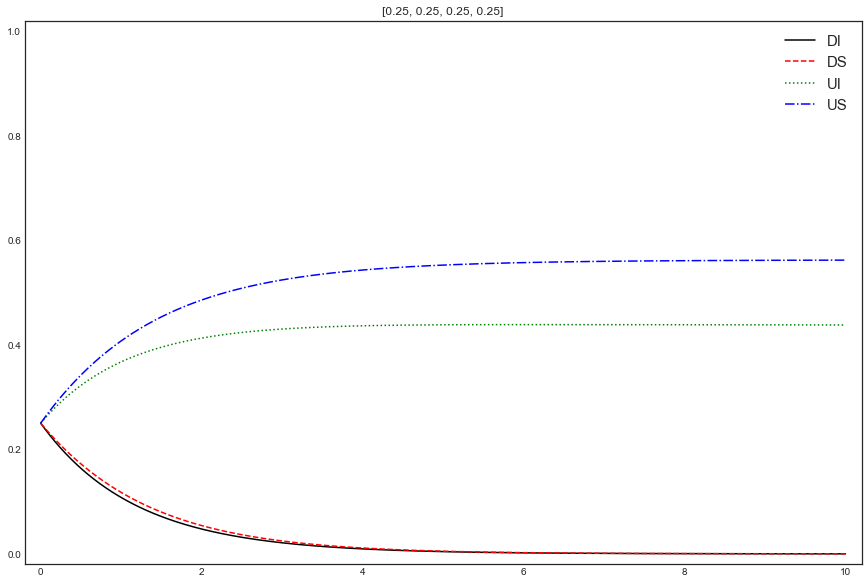

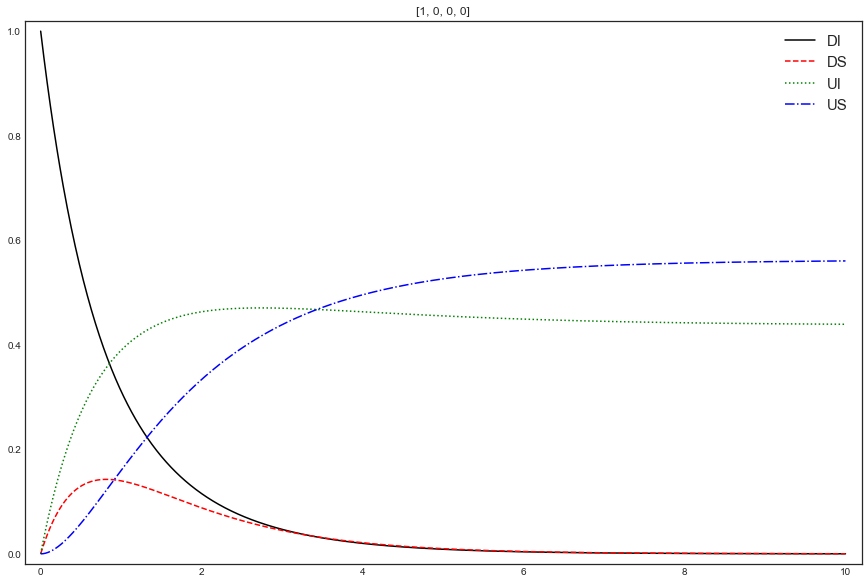

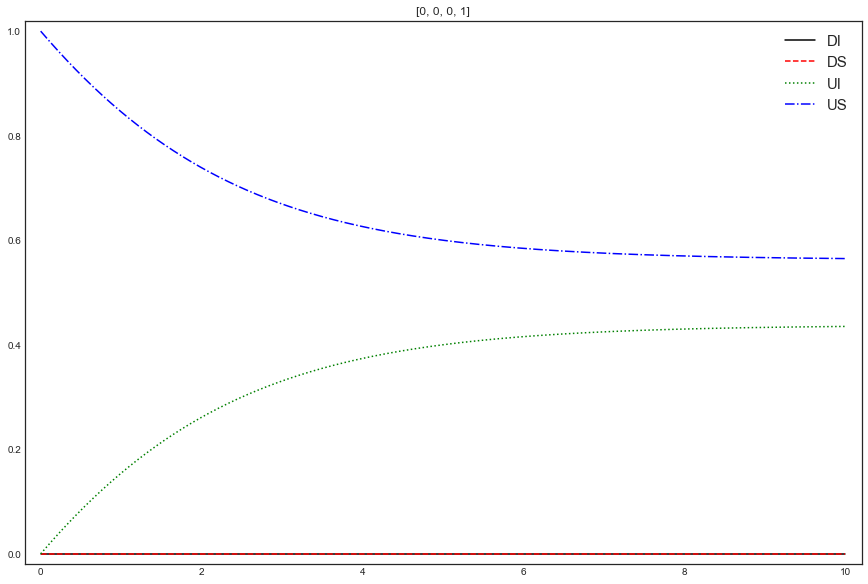

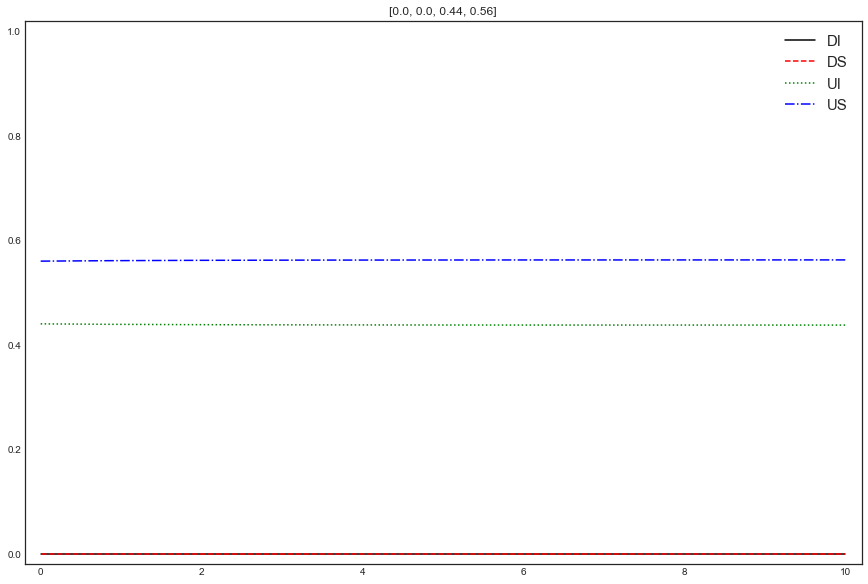

In [157]:
for μ0 in [μ0_1, μ0_2, μ0_3, μ0_4]:
    μ_flow_list, a_flow_list = solve_fixpoint(μ0, param_q, param_f)
    μ_flow_list[-1].plot(**param_plot)
    plt.title(μ0.values.tolist())
    plt.legend(fontsize=15)

# Fig 7.2

The reason $a(T,x) =0$ 0 at the right end is because $g(X_T) \equiv 0$ and action doesn't matter.

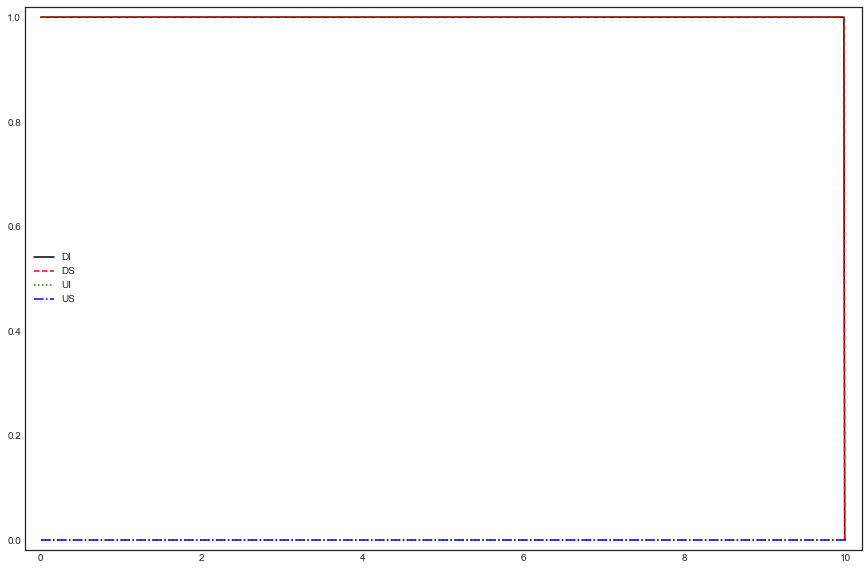

In [155]:
a_flow_list[-1].plot(**param_plot);

# Fig 7.3

In [146]:
μ_flow_list, a_flow_list = solve_fixpoint(μ0_1, param_q2, param_f2, iterations=5)

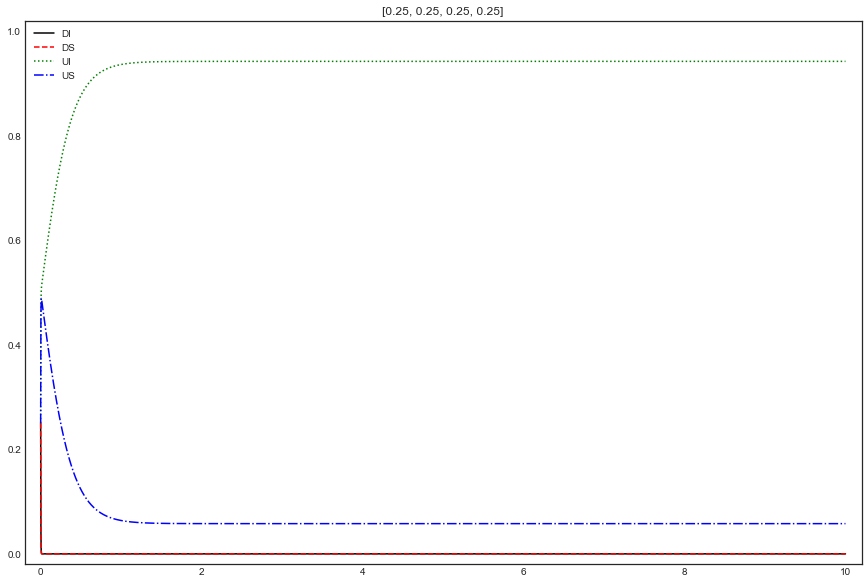

In [152]:
μ_flow_list[0].plot(**param_plot)
plt.title(μ0_1.values.tolist());

## Damn, it doesn't iterate

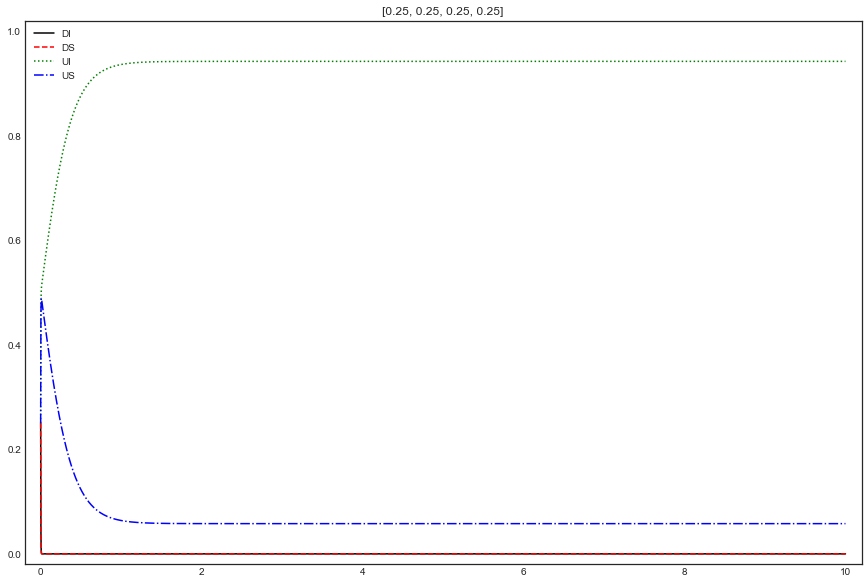

In [151]:
μ_flow_list[-1].plot(**param_plot)
plt.title(μ0_1.values.tolist());